In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# A Simple Starter Code for the AJL Competition

@Cindy Deng

---


Hi! This starter code is designed to help you get familiar with basic Kaggle operations and guide you through the basic workflow of a machine learning project. 

The code outlines essential steps including data loading, preprocessing, model building, training, and generating predictions. Each section serves as a foundation, but there are many ways to enhance each step to improve your final model's accuracy. Feel free to experiment with different data augmentation techniques, model architectures, and tuning methods to optimize your final results! Some amazing tutorials are available through your AI Studio course in Canvas / in the 'Resource' section of this Kaggle competition.

Good luck and have fun!

---

## Note - About file path

You could use the cell above to print the names of the file directories and get the following directories:

```
/kaggle/input/bttai-ajl-2025/sample_submission.csv
/kaggle/input/bttai-ajl-2025/train.csv
/kaggle/input/bttai-ajl-2025/test.csv
/kaggle/input/bttai-ajl-2025/test/test/e0374ae6c1362ff183cfba28ded5421b.jpg
/kaggle/input/bttai-ajl-2025/test/test/437159c605260bdd079af230566af291.jpg
...
...
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/11271bdf2598afdd4260db3125e1f6a5.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/732819951dcf2b53d15ea7b8bb123b71.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/6dcc7a8abb5e1c6e670101f4b6231246.jpg
/kaggle/input/bttai-ajl-2025/train/train/dermatomyositis/e63c3b3f0ab8905e204fe467cc7411f9.jpg
...
...
```



## 1. Import Necessary Libraries

In [2]:
# 1. Import Necessary Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

# Data augmentation:
import random
from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageFilter
from tensorflow.keras.preprocessing import image

# Explanation:
# - pandas and numpy: for data manipulation
# - sklearn: for splitting data and encoding labels
# - tensorflow.keras: for building and training the neural network

## 2. Load Data

Make sure to verify the file paths if you're running on a different platform.

In [3]:
# 2. Load Data
train_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/train.csv')
test_df = pd.read_csv('/kaggle/input/bttai-ajl-2025/test.csv')

print("Train columns:", train_df.columns)
print("Test columns:", test_df.columns)

# Add .jpg extension to md5hash column to reference the file_name
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Combine label and md5hash to form the correct path
train_df['file_path'] = '/kaggle/input/bttai-ajl-2025/train/train/' + train_df['label'] + '/' + train_df['md5hash']
test_df['file_path'] = '/kaggle/input/bttai-ajl-2025/test/test/' + test_df['md5hash']

print(train_df[['label', 'md5hash', 'file_path']].head())
print(test_df[['md5hash', 'file_path']].head())

sample_path = train_df.iloc[0]['file_path']
print("Sample file exists:", os.path.exists(sample_path))

Train columns: Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'label',
       'nine_partition_label', 'three_partition_label', 'qc', 'ddi_scale'],
      dtype='object')
Test columns: Index(['md5hash', 'fitzpatrick_scale', 'fitzpatrick_centaur', 'qc',
       'ddi_scale'],
      dtype='object')
                              label                               md5hash  \
0                 prurigo-nodularis  fd06d13de341cc75ad679916c5d7e6a6.jpg   
1  basal-cell-carcinoma-morpheiform  a4bb4e5206c4e89a303f470576fc5253.jpg   
2                            keloid  c94ce27e389f96bda998e7c3fa5c4a2e.jpg   
3              basal-cell-carcinoma  ebcf2b50dd943c700d4e2b586fcd4425.jpg   
4                 prurigo-nodularis  c77d6c895f05fea73a8f3704307036c0.jpg   

                                           file_path  
0  /kaggle/input/bttai-ajl-2025/train/train/pruri...  
1  /kaggle/input/bttai-ajl-2025/train/train/basal...  
2  /kaggle/input/bttai-ajl-2025/train/train/keloi...  
3  /kagg

## 3. Data Preprocessing


This section demonstrates basic preprocessing techniques. To enhance data quality and model performance, consider incorporating more advanced preprocessing methods.

For further guidance, feel free to take a look at the [Image Preprocessing tutorial](https://colab.research.google.com/drive/1-ItNcRMbZBE6BCwPT-wD8m3YmHqwHxme?usp=sharing)  available in the 'Resources' section of this Kaggle competition.


In [4]:
# 3. Data Preprocessing
# Split the data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Encode the labels
label_encoder = LabelEncoder()
train_data['encoded_label'] = label_encoder.fit_transform(train_data['label'])
val_data['encoded_label'] = label_encoder.transform(val_data['label'])

# Define image data generators for training and validation, data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the directory paths
train_dir = '/kaggle/input/bttai-ajl-2025/train/train/'

## 4. Build the model


In [5]:
# TODO: You should implement the model architecture here.
# Feel free to explore different model types that best serve your purpose.

IMG_SIZE = (128, 128)

# Build the model using EfficientNetB0 as the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

# Determine number of classes from the training data
num_classes = len(train_data['encoded_label'].unique())

# Create the model
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(21, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 21)                  │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,290,389 (16.37 MB)

 Trainable params: 4,290,389 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=438x341 at 0x7CC17F72B400>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=495x236 at 0x7CC17C2F3250>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=402x359 at 0x7CC17C2F3010>]
['fd06d13de341cc75ad679916c5d7e6a6.jpg', 'a4bb4e5206c4e89a303f470576fc5253.jpg', 'c94ce27e389f96bda998e7c3fa5c4a2e.jpg']


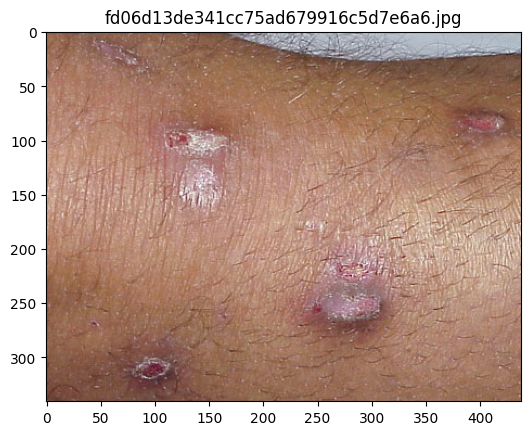

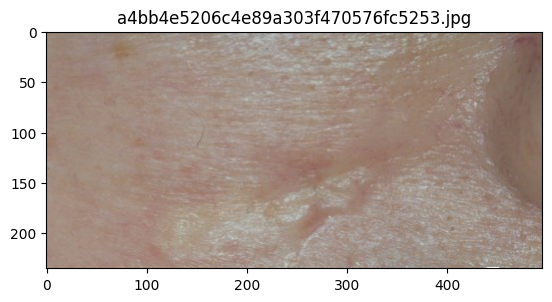

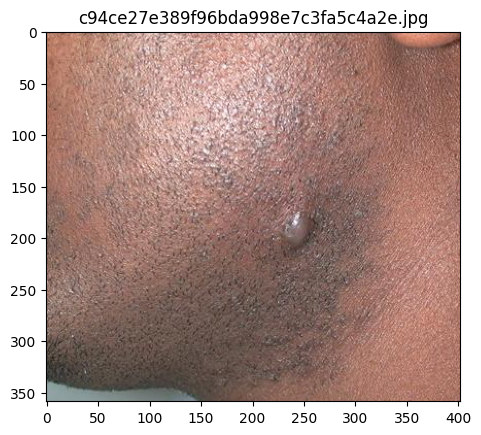

In [6]:
# Print images
file_name = train_df['md5hash'][0:3]
file_label = train_df['label'][0:3] 

images = [] 
titles = []

for i in range(len(file_name)):
    fn = os.path.splitext(file_name.iloc[i])[0]  
    image_dir = os.path.join(train_dir, file_label.iloc[i]) 
    # Append image to list
    img_path = os.path.join(image_dir, file_name.iloc[i]) 
    if os.path.exists(img_path): 
        images.append(Image.open(img_path)) 
        titles.append(file_name.iloc[i])  

print(images)
print(titles)

import matplotlib.pyplot as plt

for img, title in zip(images, titles):
    plt.imshow(img)
    plt.title(title)
    plt.show()

## 5. Train the Model


In [7]:
# TODO: Train your model here. 
train_data['encoded_label'] = train_data['encoded_label'].astype(str)
val_data['encoded_label'] = val_data['encoded_label'].astype(str)

# Generator function for training and validation data
def create_generator(dataframe, datagen, batch_size=32, target_size=(128, 128)):
    generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=None,
        x_col='file_path', 
        y_col='encoded_label', 
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        validate_filenames=False
    )
    return generator

# Create the training and validation generators
train_generator = create_generator(train_data, train_datagen)
val_generator = create_generator(val_data, val_datagen)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Found 2288 non-validated image filenames belonging to 21 classes.
Found 572 non-validated image filenames belonging to 21 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 60s 759ms/step - accuracy: 0.1217 - loss: 2.9224 - val_accuracy: 0.1678 - val_loss: 2.8191
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 639ms/step - accuracy: 0.1395 - loss: 2.8542 - val_accuracy: 0.1801 - val_loss: 2.7724
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 625ms/step - accuracy: 0.1526 - loss: 2.8159 - val_accuracy: 0.1678 - val_loss: 2.7274
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 625ms/step - accuracy: 0.1444 - loss: 2.7807 - val_accuracy: 0.1818 - val_loss: 2.7204
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 627ms/step - accuracy: 0.1788 - loss: 2.7213 - val_accuracy: 0.2045 - val_loss: 2.6700
Epoch 10/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


## 6. Make Predictions on Test Data

In [8]:
# 6. Make Predictions on Test Data
def preprocess_test_data(test_df, target_size=(128, 128)):
    """
    Template for loading and preprocessing test images.
    """
    images = []
    for img_path in test_df['file_path']:
        img = image.load_img(img_path, target_size=target_size) 
        img = image.img_to_array(img) 
        img = img / 255.0 
        images.append(img)
    
    return np.array(images)

test_images = preprocess_test_data(test_df)

print(f"Test images shape: {test_images.shape}")

test_datagen = ImageDataGenerator(rescale=1./255.0)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='file_path',
    y_col=None,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode=None,
    shuffle=False 
)

Test images shape: (1227, 128, 128, 3)
Found 1227 validated image filenames.


## 7. Generate Predictions

In [9]:
# TODO
# Generate predictions based on the trained model
# Then, save the predictions into a CSV file for submission
# Generate predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to labels
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Remove .jpg from the md5hash values to match the submission format
test_df['md5hash'] = test_df['md5hash'].str.replace('.jpg', '')

# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to class labels (assuming categorical crossentropy with softmax output)
predicted_labels = np.argmax(predictions, axis=1)

# Decode the labels back to the original class names
decoded_labels = label_encoder.inverse_transform(predicted_labels)

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'md5hash': test_df['md5hash'],
    'label': decoded_labels
})

# Save the submission file in the correct format (without index column)
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step
